# Modeling Quadrupole Transport of Charged Particle Beams with Python
Created by Emily Jevarjian, Nick Valverde, and Steve Lund 


The purpose of this code is model the phase space evolution of a beam of charged particles transported in a magnetic FODO quadrupole focusing lattice. The focusing is alternating gradient. This program describes the quadrupoles simply as "thin lens" kicks and uses linear transfer matrices to model the charged particle beam's transport. Approximate, corresponding thick (physical) quadrupole parameters are output for laboratory implementation.

User inputs are specified to set desired charged particle beam and applied focusing lattice parameters. Options can be set to model a single particle or a bundle of particles. Output plots generated help visualize the the phase-space evolution of the beam.  Plots include x and x' orbit bundles and x-x' phase-space projections made each lattice period at the same location.     

The program employs Python packages numpy and math to make calculations and uses matplotlib graphics to plot the phase space evolution of the beam.

# Load Python Packages 

In [1]:
import numpy as np
from numpy import cos, sin, pi
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Define Constants

In [2]:
# Constants

c_light  = 2.99792458e8    # speed of light [m/s]
e_charge = 1.60217662e-19  # electronic charge [C]
amu      = 1.660538921e-27 # atomic mass unit [kg]
jperev   = e_charge        # conversion factor Joules/eV
mm       = 1.e-3           # conversion factor mm to meters 
mrad     = 1.e-3           # conversion factor mrad to rad 

# Charged Particle Inputs
* Q:  particle charge state
    * Q = -1 for an electron
    * Q = a positive integer for an ion
* M:  particle mass in atomic mass units [amu]
* E:  axial kinetic energy [eV]

In [3]:
# Charged particle inputs
Q  = 1.          # particle charge state [1]
M  = 1.00727647  # particle mass [amu]
E  = 100.e3      #axial kinetic energy [eV]

# Derived parameters 
q = Q*e_charge 
m = M*amu 

energy   = jperev*E                    # Kinetic energy [J]
gamma_b  = 1. + energy/(m*c_light**2)  # relativistic axial gamma [1]
beta_b   = np.sqrt(1.-1./gamma_b**2)   # relativistic axial beta v_z/c [1]
p_z      = m*gamma_b*beta_b*c_light    # particle axial momentum [kg*m/s]
rigidity = p_z/q                       # particle rigidity [T*m]

print("Charged Particle Properties:")
print("")
print("Charge, q = {} C"  .format(q))
print("Mass,   m = {} kg" .format(m))
print("")
print("Energy, E = {} eV" .format(E))
print("          = {} J"  .format(energy))
print("")
print("gamma_b = {}" .format(gamma_b))
print("beta_b  = {}" .format(beta_b))
print("")
print("p_z      = {} kg*m/s" .format(p_z))
print("rigidity = {} Tesla*m" .format(rigidity))

Charged Particle Properties:

Charge, q = 1.60217662e-19 C
Mass,   m = 1.672621782642489e-27 kg

Energy, E = 100000.0 eV
          = 1.60217662e-14 J

gamma_b = 1.000106578900535
beta_b  = 0.014598757780230454

p_z      = 7.321172476061896e-21 kg*m/s
rigidity = 0.04569516484432219 Tesla*m


## FODO Lattice Inputs

In [4]:
#--Specify lattice 
sigma_0 = pi/3 # [rad/period] phase advance
d = 2.         # [m] full drift length
Lp = 2.*d      # [m]  lattice length

#--Calculate focal length f from phase advance 
f = (d/2.)*np.sqrt(2./(1.-cos(sigma_0))) #focal length

ell     = 0.5 # Physical (thick) quadrupole axial length [m]  (information only for lab lattice output)

kappa = 1./(f*ell)           # Physical (thick) quadrupole kappa [1/m^2]
G     = rigidity/(f*ell)     # Physical (thick) quadrupole field gradient [Tesla/m]

print("Lattice Properties:")
print("")
print("Lattice Period, L_p = {} m" .format(Lp))
print("Phase Advance, sigma_0 = {} rad/Period" .format(sigma_0))
print("                       = {} deg/Period" .format((180./pi)*sigma_0))
print("")
print("Drift Length, d = {} m" .format(d))
print("Focal Length, f = {} m" .format(f))
print("")
print("--- Thick Lens Quadrupole Equivalent")
print("Quad Axial Length,   ell   = {}" .format(ell))
print("Quad Focus Strength, kappa = {} m^(-2)" .format(kappa))
print("Quad Gradient,       G     = {} Tesla/m" .format(G))

Lattice Properties:

Lattice Period, L_p = 4.0 m
Phase Advance, sigma_0 = 1.0471975511965976 rad/Period
                       = 59.99999999999999 deg/Period

Drift Length, d = 2.0 m
Focal Length, f = 2.0 m

--- Thick Lens Quadrupole Equivalent
Quad Axial Length,   ell   = 0.5
Quad Focus Strength, kappa = 1.0 m^(-2)
Quad Gradient,       G     = 0.04569516484432219 Tesla/m


## Specify Initial Distribution of Particles

In [5]:
Np        = 150         # Number of particles 
emittance = 10.*mm*mrad # [m-rad] Courant Snyder Ellipse Size Parameter

beta  = 1.    # betatron ellipse coefficient beta [m] 
alpha = pi/4. # betatron ellipse coefficient alpha [rad]

fill  = False # False = Particles on perimeter ellipse, True = Particles uniformly fill ellipse 
match = True # False = Use beta, alpha above to set, True = Reset beta, alpha as matched beam ellipse values


# Derived distrubtion parameters 
gamma = (1+alpha**2)/beta # betatron ellipse coefficient gamma [1/m]

## Specify advance length of simulation

In [6]:
n_advance = 6  # Number of lattice periods to advance 

## Functions to create matched distriubtion of particles

In [7]:
#--Functions to calcluate Twiss parameters with inputs drift (d), focal length (f), and initial phase-angle (sigma_0).
def alpha_match(d,f, sigma_0):
    numerator = -d/f
    denominator = np.sqrt(sin(sigma_0))
    return numerator/denominator

def beta_match(d, f, sigma_0):
    numerator = 2.*d - d**3/(4.*f**2)
    denominator = sin(sigma_0)
    return numerator/denominator

def gamma_match(d, f, sigma_0):
    numerator = sin(sigma_0) + d**2/f**2
    denominator = 2.*d - d**3/(4.*f**2)
    return numerator/denominator


def create_particles (d, f, sigma_0, gamma, alpha, beta, emittance, Np, fill, match):
    '''
    Create distribution of initial x,x' coordinates for n particles in specified Courant-Snyder 
    phase-space ellipse given by 
       gamma*x^2 + 2*alpha*x*x' + beta*(x')^2 = emittance 
    Filled = False => distribute n particles around perimeter 
           = True  => uniformly fill n particles within ellipse 
    Note: This routine has no knowledge of whether the ellipse parameters gamma, alpha, beta, emit 
    correspond to a matched beam or not. 
    '''
    
    #--Initialze x and x' arrays to be populated
    x = []
    xprime = []
    count = 0 #Counter for while loops

    #--Check Match condition: reset gamma, alpha, beta if matched beam desired, otherwise use input values 
    if match == True:
        alpha, beta, gamma = alpha_match(d, f, sigma_0), beta_match(d, f, sigma_0), gamma_match(d, f, sigma_0)
        

        #--Calculate w
        numerator = np.sqrt(2.*d - d**3/(4.*f**2))
        w = np.sqrt(beta)
        #--Calculate w'
        wp = -alpha/w

        #--Output twiss parameters
        print("Courant-Snyder Ellipse Parameters of Load:")
        print("")
        print("emittance = %f mm-mrad" %(emittance/(mm*mrad))) 
        print("")
        print("alpha = %f" %alpha)
        print("beta  = %f m" %beta)
        print("gamma = %f m^-1" %gamma)
        print("")
        print("w  = %f m^(1/2)" %w)
        print("w' = %f m^(-1/2)"%wp)
        
    else:
        w = np.sqrt(beta)
        wp = -alpha/w
        
        #--Output twiss parameters

        print("Courant-Snyder Ellipse Parameters of Load:")
        print("")
        print("emittance = %f mm-mrad" %(emittance/(mm*mrad))) 
        print("")
        print("alpha = %f" %alpha)
        print("beta  = %f m" %beta)
        print("gamma = %f m^-1" %gamma)
        print("")
        print("w  = %f m^(1/2)" %w)
        print("w' = %f m^(-1/2)"%wp)
        
           
    if fill == False: # Perimeter load
        while count < Np:
            theta = 2.*pi*count/Np
            xpos = np.sqrt(emittance)*w*cos(theta)
            xprime_pos = np.sqrt(emittance)*sin(theta)/w + np.sqrt(emittance)*wp*cos(theta)

            x.append(xpos)
            xprime.append(xprime_pos)
            count += 1

    else: # Uniform load
        while count < Np:
            #--Fill  Procedure
            up = np.sqrt(np.random.random())
            upsi = np.random.random()
            psi = 2.*pi*upsi
            xpos = np.sqrt(emittance)*up*w*cos(psi)
            xprime_pos = np.sqrt(emittance)*up*sin(psi)/w + np.sqrt(emittance)*up*wp*cos(psi)

            x.append(xpos)
            xprime.append(xprime_pos)
            count +=1
        
    #--Turn x and xprime into np arrays 
    x = np.array(x)
    xprime = np.array(xprime)

    return x, xprime

## Procedure to advance particles through lattice

In [8]:
#-Create FODO Matrices
M0 = np.array( [[1.,d/2.],[0,1.]] )      # drift matrix
Mf = np.array( [[1.,0],[-1./f,1.]] )     # focus matrix
Md = np.array( [[1.,0],[ 1./f,1.]] )     # defocus matrix
def advance(x, xprime, Matrix): #advance particles 
    x_new = []
    xprime_new = []

    #The create_particles gives two arrays of intitial particle coordinates. For each particle, take the 
    #x and x' coordintates and advance through the FODO element Matrix. Then, append the new coordinates to x_new
    #and xprime_new and update x and xprime at the end. 
    for i in range(len(x)):
        a = x[i] #a and b aid in creating vec
        b = xprime[i]
        vec = np.array([[a], [b]])
        
        #advance particle
        vec = Matrix@vec 
        #append new coordinates
        
        x_new.append(vec[0][0]) #append new 
        xprime_new.append(vec[1][0])
    
    #update original x and xprime
    x, xprime = np.array(x_new), np.array(xprime_new)
    return x, xprime


## Ellipse Plot Routine


In [9]:
def ellipse_plot(x, xprime, s, Lp, labels = False):
            
    fig, ax = plt.subplots(figsize=(7,7))
    ax.scatter(x/mm, xprime/mrad, s = 0.5)
    ax.axhline(y=0, lw=.5, c='k')
    ax.axvline(x=0, lw=.5, c='k')
    ax.set_title(r"$x$-$x'$ Phase-Space at Periods, $s/L_p =$ %g" %(s/Lp), fontsize = 18)
    ax.set_xlabel(r'$x$[mm]', fontsize = 18)
    ax.set_ylabel(r"x'[mrad]", fontsize = 18)

    
    #--Label max x and x'
    if labels == True:
        #--Major axis coordinates
        x_axis_coords = []
        for k in range(len(x)):
            if x[k] == max(x):
                x_axis_coords.append(x[k])
                x_axis_coords.append(xprime[k])
            else:
                continue

        xp_axis_coords = []
        for k in range(len(xprime)):
            if xprime[k] == max(xprime):
                xp_axis_coords.append(x[k])
                xp_axis_coords.append(xprime[k])
            else:
                continue
                
        x_axis_coords = np.array(x_axis_coords)
        xp_axis_coords = np.array(xp_axis_coords)
        
        #--Plot x-max point and xp-max point
        xmax = x_axis_coords[0]
        xpmax = xp_axis_coords[1]
        ax.axvline(x = xmax/mm, c = 'b', ls = '--', lw = .75) # x max line
        ax.axhline(y = xpmax/mrad, c = 'b', ls = '--', lw = .75) # xp max line
        
        #--label x max
        x_annote = "$x_{max}$ = %1.3f" %(x_axis_coords[0]/mm)
        ax.annotate(x_annote, (xmax/mm, x_axis_coords[1]/mrad))

        #--label x' max
        xp_annote = "$x'_{max} =$ %1.3f" %(xpmax/mm)
        ax.annotate(xp_annote, (xp_axis_coords[0]/mm, xpmax/mrad))
        
    else:
        pass
        
        
    return True

## Main procedure to advance particles 

Courant-Snyder Ellipse Parameters of Load:

emittance = 10.000000 mm-mrad

alpha = -1.074570
beta  = 4.041452 m
gamma = 0.533150 m^-1

w  = 2.010336 m^(1/2)
w' = 0.534522 m^(-1/2)


True

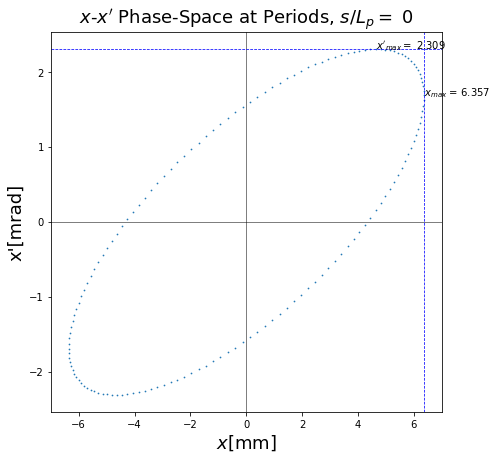

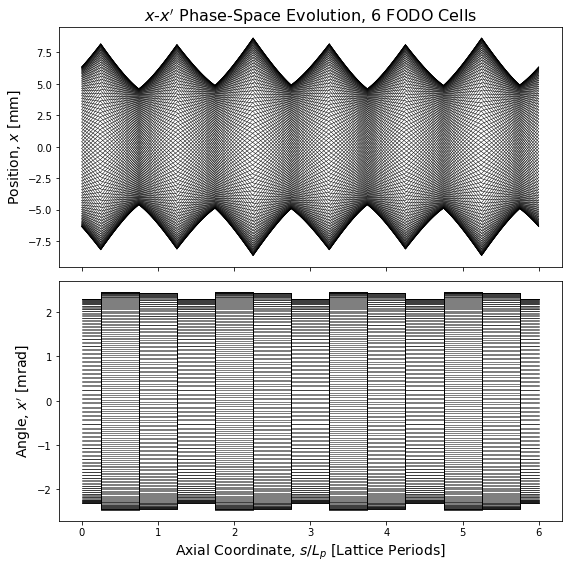

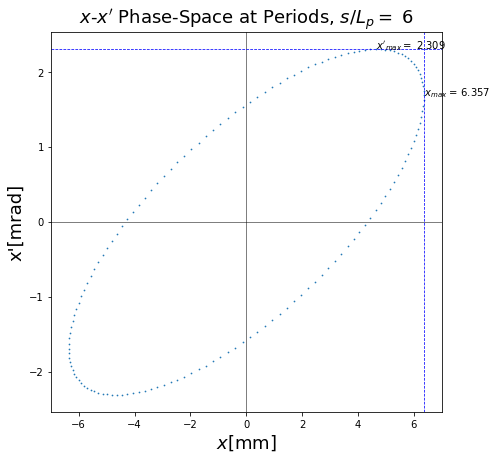

In [10]:
# Create particles
x, xprime = create_particles(d, f, sigma_0, gamma, alpha, beta, emittance, Np, fill, match)
ellipse_plot(x, xprime, 0, Lp, labels = True)

# Advance particles 
x_history = [x]
xp_history = [xprime]
s_history = [0]
s = 0
lattice_advances = 0
while lattice_advances < n_advance:
    #Pass through half-drift
    x, xprime = advance(x,xprime, M0)
    x_history.append(x)
    xp_history.append(xprime)
    s += d/2.
    s_history.append(s)
    
    #Pass through focus
    x, xprime = advance(x, xprime, Mf)
    x_history.append(x)
    xp_history.append(xprime)
    s += 0
    s_history.append(s)

    
     #Pass through two half-drifts 
    x, xprime = advance(x,xprime, M0)
    x_history.append(x)
    xp_history.append(xprime)
    s += d/2.
    s_history.append(s)

    x, xprime = advance(x,xprime, M0)
    x_history.append(x)
    xp_history.append(xprime)
    s += d/2.
    s_history.append(s)
    
    #Pass through defocus
    x, xprime = advance(x, xprime, Md)
    x_history.append(x)
    xp_history.append(xprime)
    s += 0
    s_history.append(s)
    
    #Pass through half-drift
    x, xprime = advance(x,xprime, M0)
    x_history.append(x)
    xp_history.append(xprime)
    s += d/2.
    s_history.append(s)
    
    lattice_advances += 1
    
    
x_history = np.array(x_history)
xp_history = np.array(xp_history)    
s_history = np.array(s_history)

#--Plot x and x' trajectories vs lattice periods 
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (8,8), sharex = True)
ax_pos = axes[0]
ax_phase_space = axes[1]

ax_pos.plot(s_history/Lp, x_history/mm, c = 'k', lw = .5)
ax_pos.set_title(r"$x$-$x'$ Phase-Space Evolution, %g FODO Cells" %n_advance, fontsize = 16)
ax_pos.set_ylabel(r'Position, $x$ [mm]', fontsize = 14)

ax_phase_space.plot(s_history/Lp, xp_history/mrad, c = 'k', lw = .5)
#ax_phase_space.set_title('Phase Space Evolution through %g FODO Cells' %n_advance)
ax_phase_space.set_ylabel(r"Angle, $x'$ [mrad]", fontsize = 14)
ax_phase_space.set_xlabel(r"Axial Coordinate, $s/L_p$ [Lattice Periods]", fontsize = 14)
plt.tight_layout()

#--Plot final ellipse
ellipse_plot(x,xprime,s,Lp, labels = True)